In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# File lists
estrogen_files = ["Channel43.txt", "72.txt", "53.txt"]
control_files = ["Control 1.txt", "Control 2.txt", "Control 3.txt"]

# Function to load and clean a file
def load_signal(file_path):
    df = pd.read_csv(file_path, delim_whitespace=True, skiprows=2, encoding='ISO-8859-1', header=None)
    df.columns = ['Time (ms)', 'Voltage (uV)']
    df['Time (ms)'] = pd.to_numeric(df['Time (ms)'], errors='coerce')
    df['Voltage (uV)'] = pd.to_numeric(df['Voltage (uV)'], errors='coerce')
    return df.dropna()

estrogen_signals = {}
control_signals = {}

for file in estrogen_files:
    df = load_signal(file)
    estrogen_signals[file] = df["Voltage (uV)"].to_numpy()

for file in control_files:
    df = load_signal(file)
    control_signals[file] = df["Voltage (uV)"].to_numpy()



/var/folders/dz/bv03mwln0nv14nvj8cybn2xc0000gn/T/ipykernel_99012/2599737753.py:12: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delim_whitespace=True, skiprows=2, encoding='ISO-8859-1', header=None)
/var/folders/dz/bv03mwln0nv14nvj8cybn2xc0000gn/T/ipykernel_99012/2599737753.py:12: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delim_whitespace=True, skiprows=2, encoding='ISO-8859-1', header=None)
/var/folders/dz/bv03mwln0nv14nvj8cybn2xc0000gn/T/ipykernel_99012/2599737753.py:12: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delim_whitespace=True, skiprows=2, encoding='ISO-8859-1', header=None)
/var/folders/dz/bv03mwln0nv14nvj8cybn2xc0000gn/T/ipykernel_99012/2599737753.py:12: DtypeWarning: Columns (0,1) have mixed types. Specify dtype

In [7]:
def plot_full_signal(sample_name, group_dict, fs=50000):
    signal = group_dict[sample_name]
    time_ms = np.arange(len(signal)) / fs * 1000

    if group_dict is control_signals:
        color = 'red'
    else:
        color = 'blue'


    plt.figure(figsize=(16, 5))
    plt.plot(time_ms, signal, color=color, linewidth=0.3)
    plt.title(f"Full Signal – Sample {sample_name}")
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage (µV)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



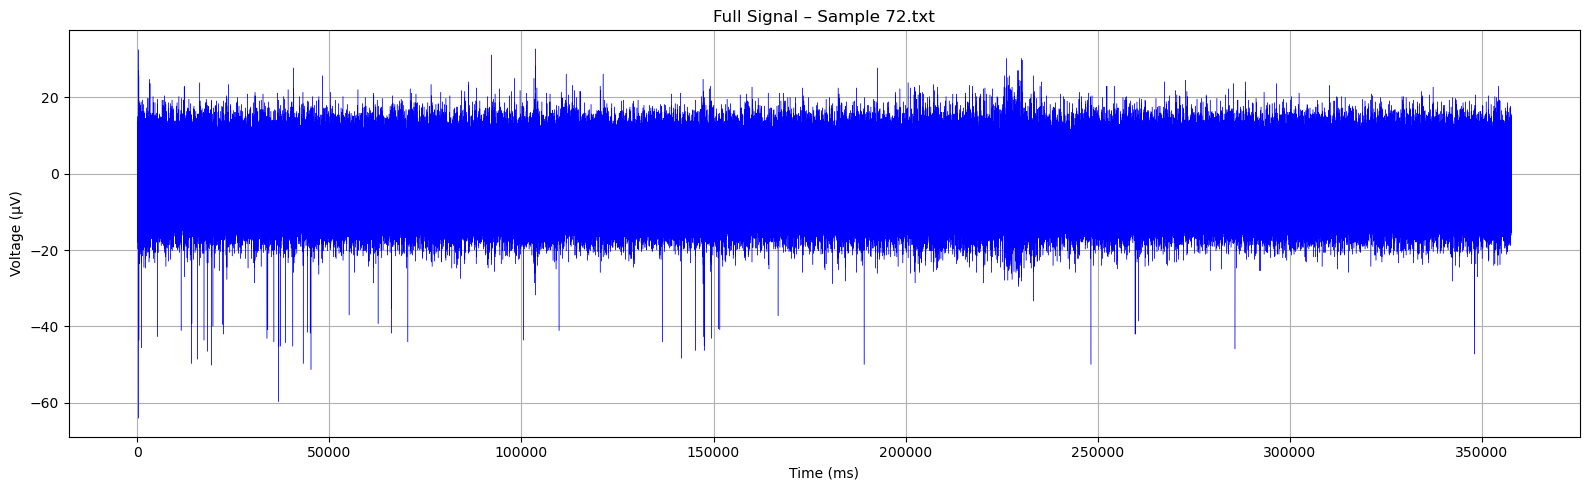

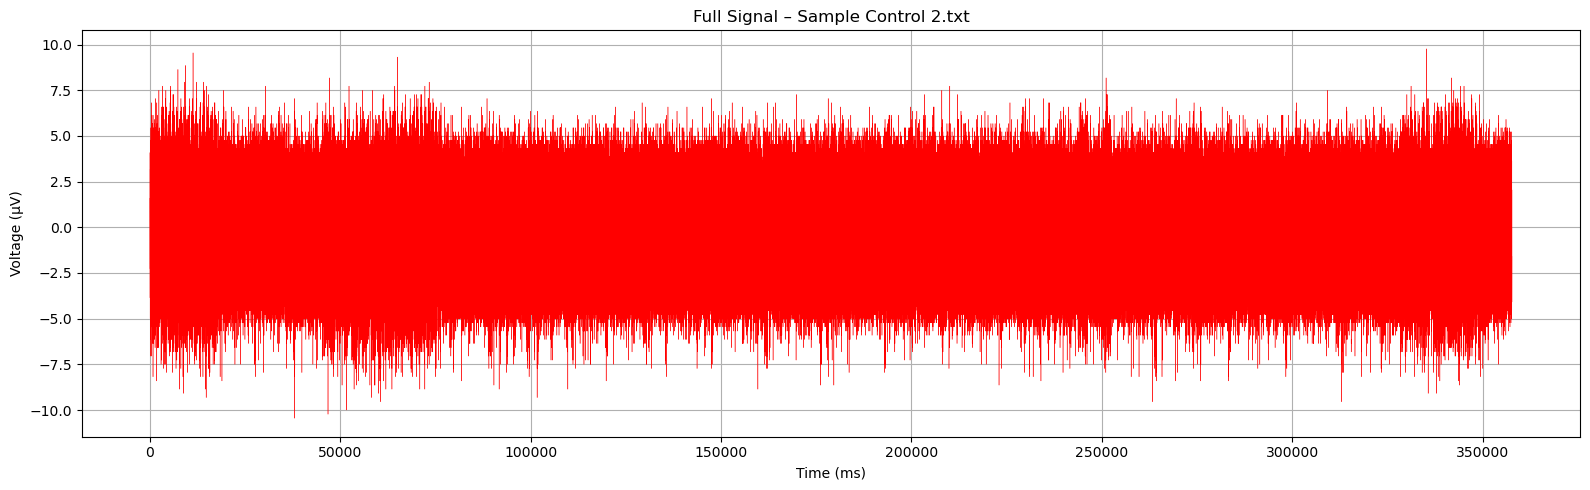

In [8]:
plot_full_signal("72.txt", group_dict=estrogen_signals)
plot_full_signal("Control 2.txt", group_dict=control_signals)


In [18]:
def detect_spikes(signal, threshold=-20, fs=50000, min_interval_ms=1):
    min_interval_samples = int(min_interval_ms / 1000 * fs)
    raw_indices = np.where(signal < threshold)[0]
    filtered = []
    last_spike = -min_interval_samples
    for idx in raw_indices:
        if idx - last_spike >= min_interval_samples:
            filtered.append(idx)
            last_spike = idx
    return np.array(filtered)


In [21]:
def verify_sample(sample_name, group_dict, fs=50000, threshold=-20, second=10):
    signal = group_dict[sample_name]
    start = second * fs
    end = (second + 1) * fs
    segment = signal[start:end]
    time_ms = np.arange(start, end) / fs * 1000

    spikes = detect_spikes(segment, threshold, fs)
    spike_times = spikes / fs
    isi = np.diff(spike_times)

    print(f"\n🧪 Sample: {sample_name} – {second}th Second")
    print(f"Spikes detected: {len(spikes)}")
    print("First 5 ISIs (s):", isi[:5] if len(isi) > 0 else "None")

    if group_dict is control_signals:
        color = 'red'
    else:
        color = 'blue'

    plt.figure(figsize=(12, 4))
    plt.plot(time_ms, segment, color = color)
    plt.title(f"{sample_name} – {second}th Second")
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage (µV)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



🧪 Sample: Channel43.txt – 10th Second
Spikes detected: 14
First 5 ISIs (s): [0.05142 0.01874 0.39004 0.0762  0.02004]


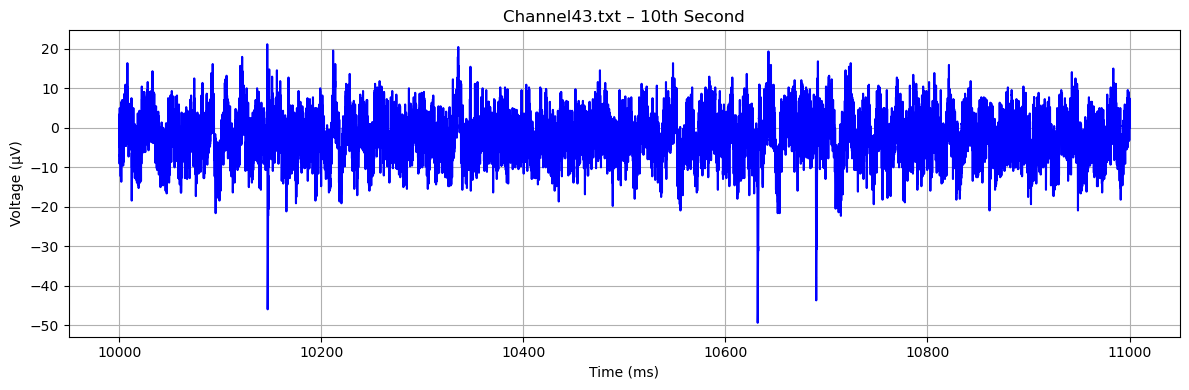


🧪 Sample: Control 2.txt – 10th Second
Spikes detected: 0
First 5 ISIs (s): None


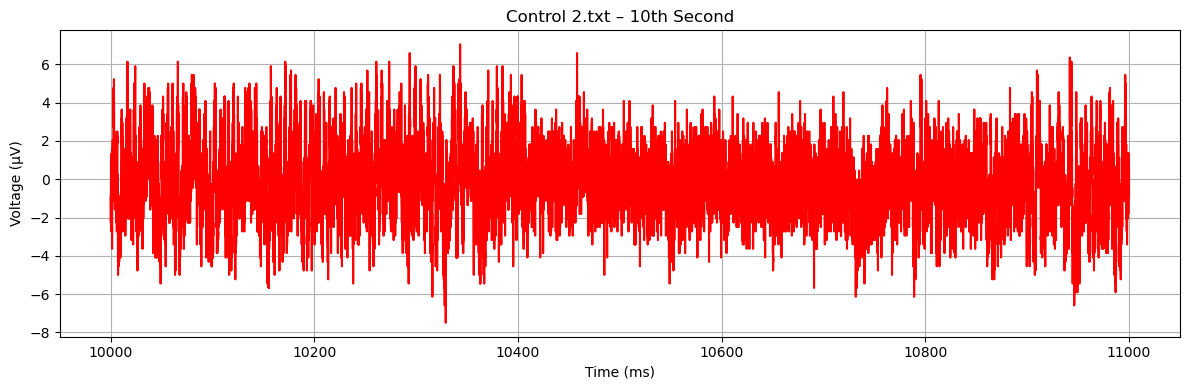

In [22]:
verify_sample("Channel43.txt", group_dict=estrogen_signals)
verify_sample("Control 2.txt", group_dict=control_signals)

In [35]:
def extract_spike_features(data, fs=50000, threshold=-40):
    window_size = fs  # 1 second
    num_windows = len(data) // window_size
    feature_list = []

    for i in range(num_windows):
        segment = data[i * window_size : (i + 1) * window_size]

        # Spike detection
        raw_spike_indices = np.where(segment < threshold)[0]
        filtered_spike_indices = []
        last_spike = -int(0.001 * fs)

        for idx in raw_spike_indices:
            if idx - last_spike >= int(0.001 * fs):
                filtered_spike_indices.append(idx)
                last_spike = idx

        spike_indices = np.array(filtered_spike_indices)
        spike_times_sec = spike_indices / fs
        isi_sec = np.diff(spike_times_sec)

        firing_rate = len(spike_times_sec)
        isi_mean = np.mean(isi_sec) if len(isi_sec) > 0 else 0

        spike_amplitudes = segment[spike_indices] if len(spike_indices) > 0 else np.array([np.nan])
        amp_min = np.min(spike_amplitudes)
        amp_mean = np.mean(spike_amplitudes)
        amp_std = np.std(spike_amplitudes)

        # New burst definition: start = 4 spikes in 50 ms, continue while ISI < 25 ms
        bursts = []
        i_burst = 0
        while i_burst <= len(spike_times_sec) - 4:
            if spike_times_sec[i_burst + 3] - spike_times_sec[i_burst] <= 0.05:
                burst = [spike_times_sec[i_burst]]
                j = i_burst + 1
                while j < len(spike_times_sec):
                    if spike_times_sec[j] - burst[-1] < 0.025:
                        burst.append(spike_times_sec[j])
                        j += 1
                    else:
                        break
                if len(burst) >= 4:
                    bursts.append(burst)
                i_burst = j
            else:
                i_burst += 1

        # Feature extraction from bursts
        burst_durations = []
        intra_rates = []
        intra_isis = []
        spikes_in_bursts = 0

        for b in bursts:
            dur = b[-1] - b[0]
            dur_ms = dur * 1000
            if dur > 0 and len(b) > 1:
                burst_durations.append(dur)
                intra_rates.append((len(b) - 1) / dur_ms) 
                intra_isis.extend(np.diff(b))
                spikes_in_bursts += len(b)

        avg_burst_duration = np.mean(burst_durations) if burst_durations else 0
        avg_intra_rate = np.mean(intra_rates) if intra_rates else 0
        avg_intra_isi = np.mean(intra_isis) if intra_isis else 0
        burst_count = len(bursts)
        burstiness_ratio = spikes_in_bursts / firing_rate if firing_rate > 0 else 0

        feature_list.append({
            "Window": i + 1,
            "Firing Rate (Hz)": firing_rate,
            "Mean ISI (s)": isi_mean,
            "Spike Amplitude Min (µV)": amp_min,
            "Spike Amplitude Mean (µV)": amp_mean,
            "Spike Amplitude Std (µV)": amp_std,
            "Avg Burst Duration (s)": avg_burst_duration,
            "Avg Intra-Burst Rate (Hz)": avg_intra_rate,
            "Avg Intra-Burst ISI (s)": avg_intra_isi,
            "Burst Count": burst_count,
            "Burstiness Ratio": burstiness_ratio
        })

    return pd.DataFrame(feature_list)



In [36]:
def extract_features_for_group(signal_dict, group_label, fs=50000, threshold=-40):
    all_features = []

    for sample_name, signal in signal_dict.items():
        df = extract_spike_features(signal, fs=fs, threshold=threshold)
        df["Sample"] = sample_name
        df["Group"] = group_label
        all_features.append(df)

    return pd.concat(all_features, ignore_index=True)


In [38]:
# Calculate the mean of each feature per sample
sample_summary_df = all_features_df.groupby(["Sample", "Group"]).mean(numeric_only=True).reset_index()

# Show the summary
print(sample_summary_df.head())


          Sample     Group  Window  Firing Rate (Hz)  Mean ISI (s)  \
0         53.txt  Estrogen   179.0          0.089636      0.000939   
1         72.txt  Estrogen   179.0          0.126050      0.004405   
2  Channel43.txt  Estrogen   179.0          0.022409      0.000761   
3  Control 1.txt   Control   179.0          0.000000      0.000000   
4  Control 2.txt   Control   179.0          0.000000      0.000000   

   Spike Amplitude Min (µV)  Spike Amplitude Mean (µV)  \
0                -44.423077                 -43.030962   
1                -41.624118                 -41.468284   
2                -41.555000                 -41.492222   
3                       NaN                        NaN   
4                       NaN                        NaN   

   Spike Amplitude Std (µV)  Avg Burst Duration (s)  \
0                  0.821311                0.000034   
1                  0.148977                0.000000   
2                  0.064612                0.000000   
3         

In [37]:
# Run extraction
estrogen_features = extract_features_for_group(estrogen_signals, group_label="Estrogen")
control_features = extract_features_for_group(control_signals, group_label="Control")

# Combine into one dataset
all_features_df = pd.concat([estrogen_features, control_features], ignore_index=True)

# Preview
print(all_features_df.head())


   Window  Firing Rate (Hz)  Mean ISI (s)  Spike Amplitude Min (µV)  \
0       1                 0           0.0                       NaN   
1       2                 0           0.0                       NaN   
2       3                 0           0.0                       NaN   
3       4                 0           0.0                       NaN   
4       5                 0           0.0                       NaN   

   Spike Amplitude Mean (µV)  Spike Amplitude Std (µV)  \
0                        NaN                       NaN   
1                        NaN                       NaN   
2                        NaN                       NaN   
3                        NaN                       NaN   
4                        NaN                       NaN   

   Avg Burst Duration (s)  Avg Intra-Burst Rate (Hz)  Avg Intra-Burst ISI (s)  \
0                     0.0                        0.0                      0.0   
1                     0.0                        0.0          

In [39]:
# Display extracted features for each sample separately
for sample_name in all_features_df["Sample"].unique():
    sample_df = all_features_df[all_features_df["Sample"] == sample_name]

    print(f"\n🔎 Features for Sample: {sample_name} (Group: {sample_df['Group'].iloc[0]})")
    display(sample_df.drop(columns=["Group", "Sample"]))  # cleaner output



🔎 Features for Sample: Channel43.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
0,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
2,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
3,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
4,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
352,353,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
353,354,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
354,355,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
355,356,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: 72.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
357,1,2,0.15002,-41.59,-41.475,0.115,0.0,0.0,0.0,0,0.0
358,2,1,0.00000,-42.95,-42.950,0.000,0.0,0.0,0.0,0,0.0
359,3,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
360,4,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
361,5,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
709,353,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
710,354,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
711,355,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
712,356,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: 53.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
714,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
715,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
716,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
717,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
718,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1066,353,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1067,354,1,0.0,-40.91,-40.91,0.0,0.0,0.0,0.0,0,0.0
1068,355,1,0.0,-46.82,-46.82,0.0,0.0,0.0,0.0,0,0.0
1069,356,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: Control 1.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
1071,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1072,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1073,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1074,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1075,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1423,353,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1424,354,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1425,355,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1426,356,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: Control 2.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
1428,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1429,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1430,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1431,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1432,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1780,353,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1781,354,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1782,355,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1783,356,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: Control 3.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
1785,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1786,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1787,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1788,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1789,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2137,353,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
2138,354,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
2139,355,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
2140,356,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0


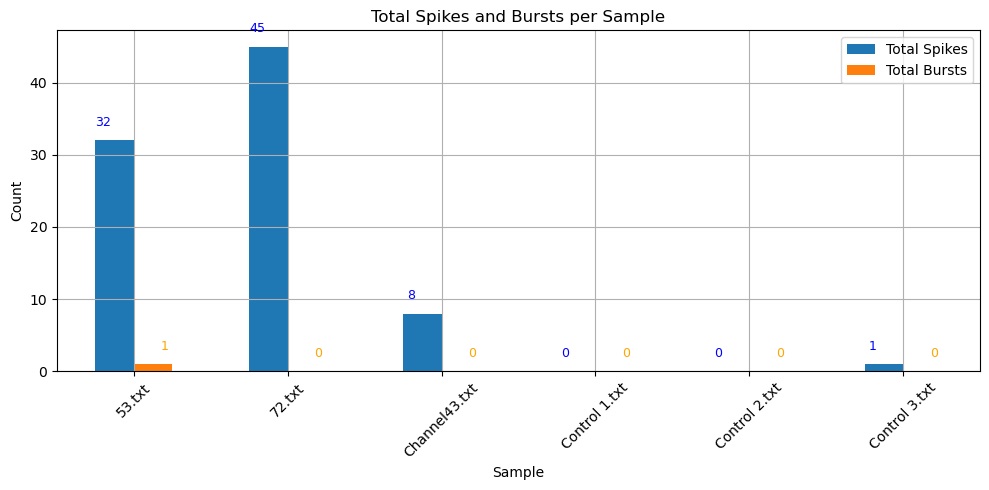

In [40]:

# Calculate totals from all_features_df
total_spikes = all_features_df.groupby("Sample")["Firing Rate (Hz)"].sum()
total_bursts = all_features_df.groupby("Sample")["Burst Count"].sum()

# Merge into one dataframe
totals_df = pd.DataFrame({
    "Total Spikes": total_spikes,
    "Total Bursts": total_bursts
}).reset_index()

# Add group labels
sample_groups = all_features_df[["Sample", "Group"]].drop_duplicates()
totals_df = totals_df.merge(sample_groups, on="Sample")

# Plot total spikes and bursts with values
ax = totals_df.plot(x="Sample", y=["Total Spikes", "Total Bursts"], kind="bar", figsize=(10, 5))
plt.title("Total Spikes and Bursts per Sample")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Annotate exact values
for i, row in totals_df.iterrows():
    ax.text(i - 0.2, row["Total Spikes"] + 2, f'{int(row["Total Spikes"])}', color='blue', ha='center', fontsize=9)
    ax.text(i + 0.2, row["Total Bursts"] + 2, f'{int(row["Total Bursts"])}', color='orange', ha='center', fontsize=9)

plt.show()



In [31]:
# Per-sample averages across all features
feature_means = all_features_df.groupby(["Sample", "Group"]).mean(numeric_only=True).reset_index()

# Group metrics by type (for clean plotting)
seconds_features = [
    "Mean ISI (s)", "Avg Burst Duration (s)", "Avg Intra-Burst ISI (s)"
]
rate_features = [
    "Firing Rate (Hz)", "Avg Intra-Burst Rate (Hz)"
]
amplitude_features = [
    "Spike Amplitude Min (µV)", "Spike Amplitude Mean (µV)", "Spike Amplitude Std (µV)"
]
count_features = [
    "Burst Count", "Burstiness Ratio"
]


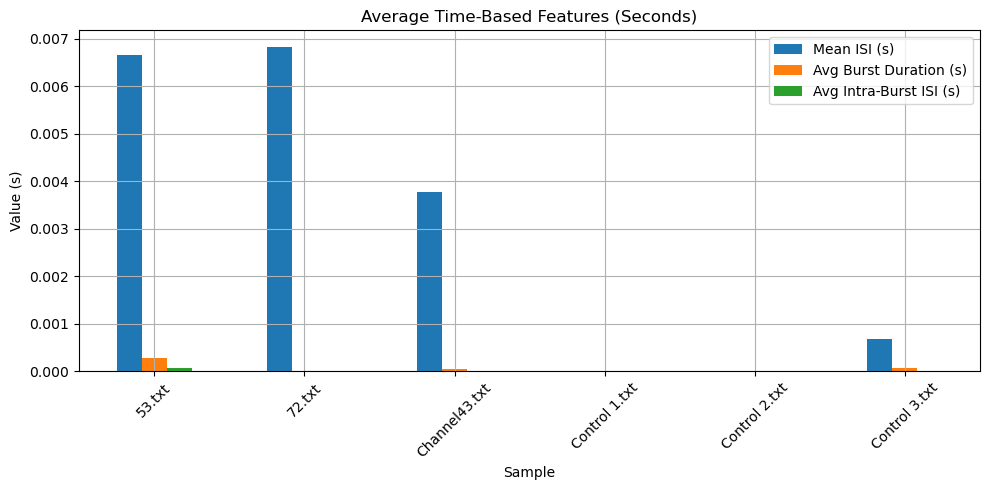

In [92]:
feature_means.set_index("Sample")[seconds_features].plot(kind="bar", figsize=(10, 5))
plt.title("Average Time-Based Features (Seconds)")
plt.ylabel("Value (s)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


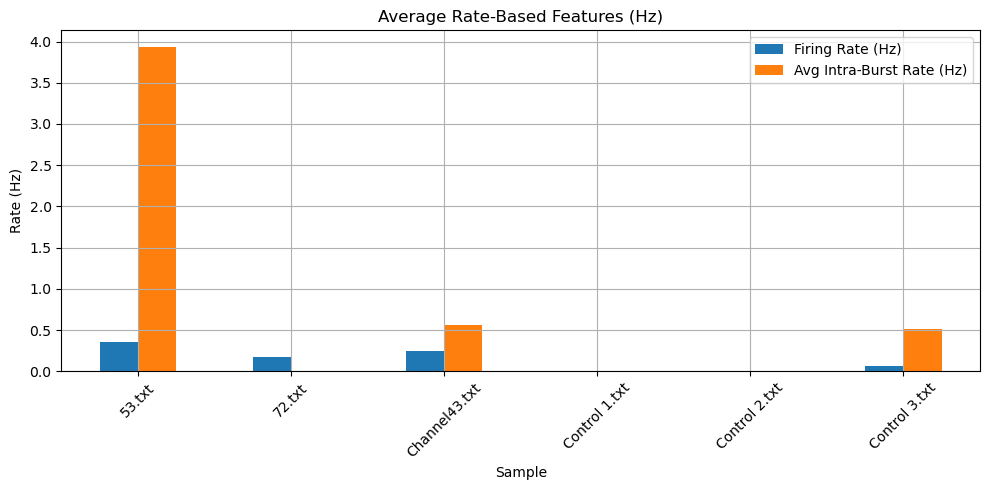

In [93]:
feature_means.set_index("Sample")[rate_features].plot(kind="bar", figsize=(10, 5))
plt.title("Average Rate-Based Features (Hz)")
plt.ylabel("Rate (Hz)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


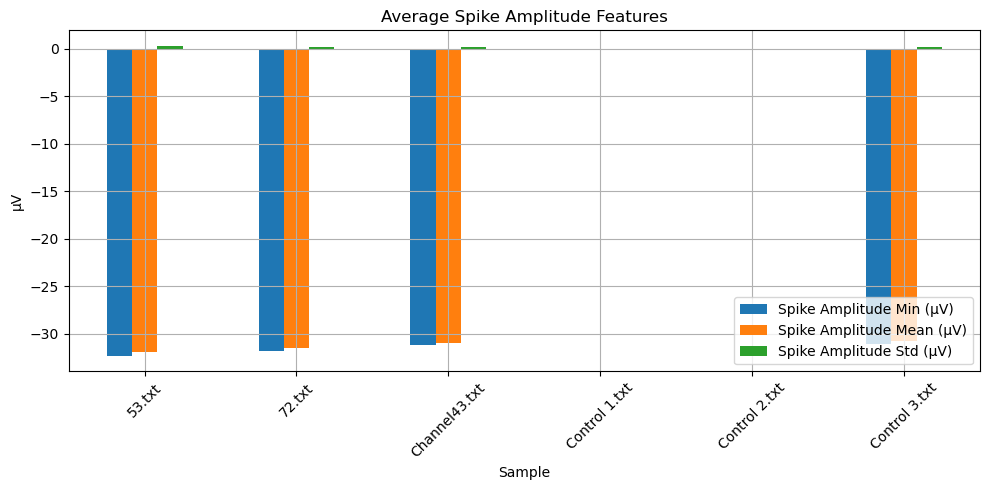

In [71]:
feature_means.set_index("Sample")[amplitude_features].plot(kind="bar", figsize=(10, 5))
plt.title("Average Spike Amplitude Features")
plt.ylabel("µV")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


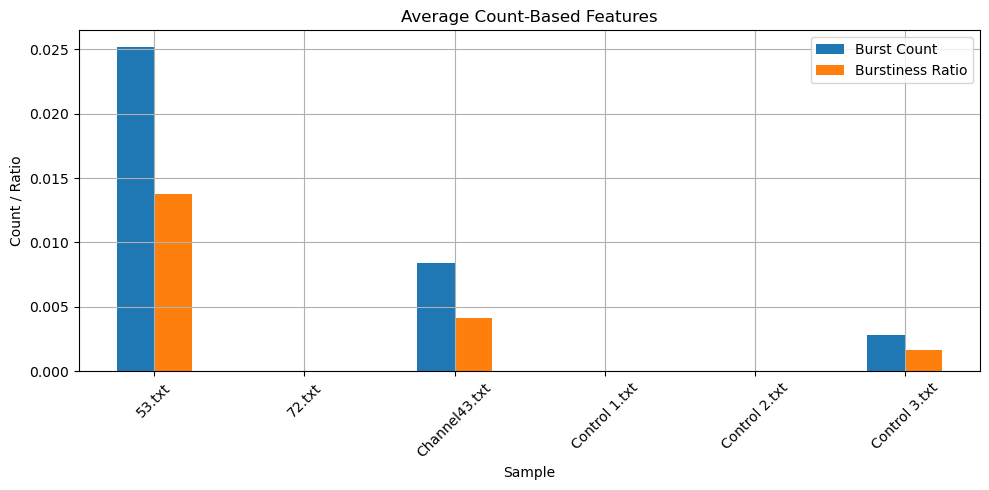

In [72]:
feature_means.set_index("Sample")[count_features].plot(kind="bar", figsize=(10, 5))
plt.title("Average Count-Based Features")
plt.ylabel("Count / Ratio")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


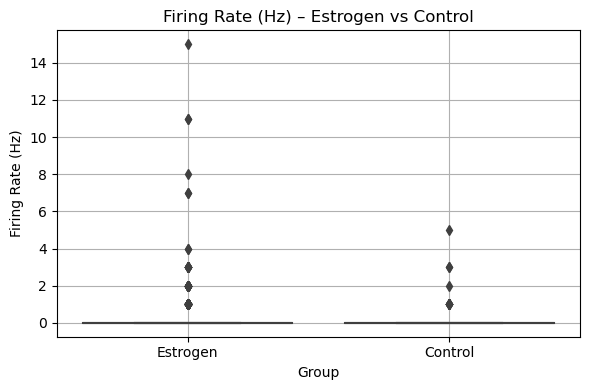

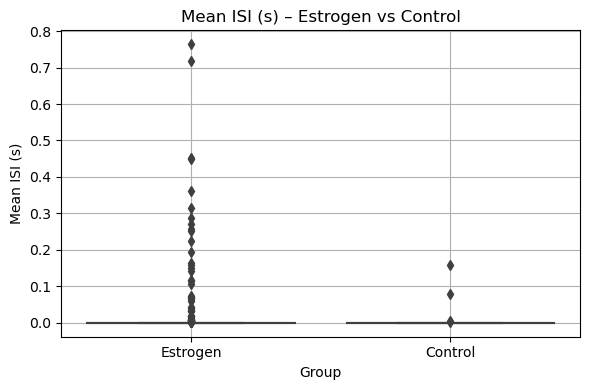

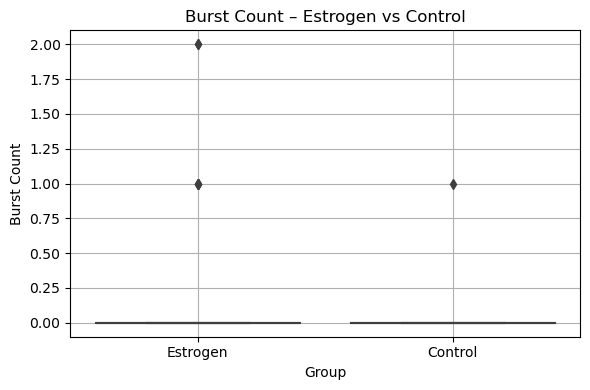

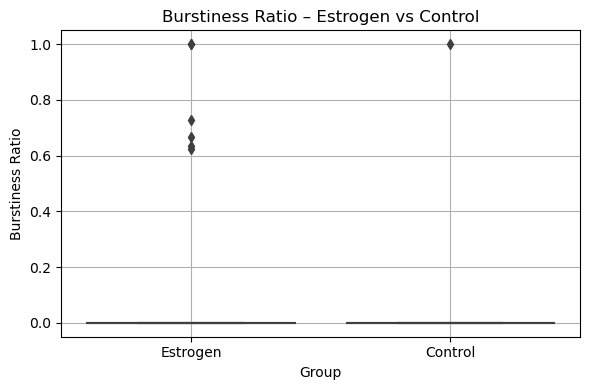

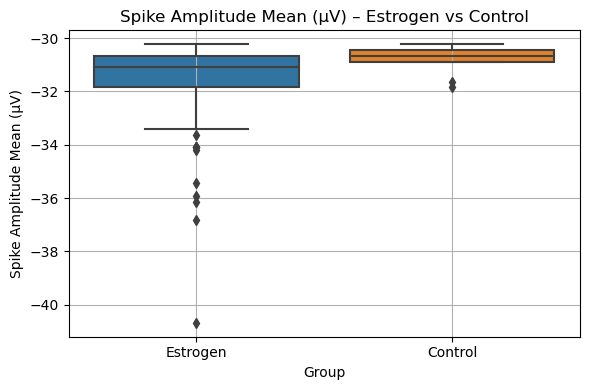

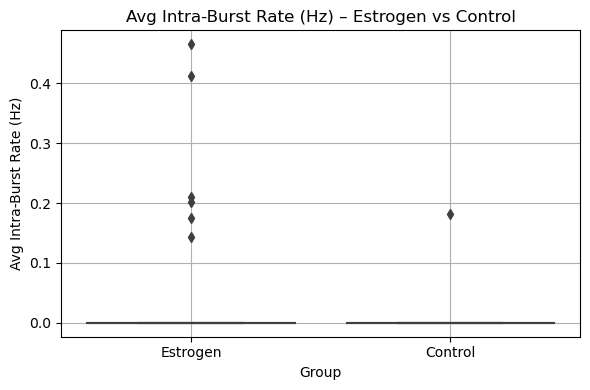

In [109]:
import seaborn as sns

# You can loop this for all features or pick key ones
features_to_compare = [
    "Firing Rate (Hz)", "Mean ISI (s)", "Burst Count", "Burstiness Ratio",
    "Spike Amplitude Mean (µV)", "Avg Intra-Burst Rate (Hz)"
]

for feature in features_to_compare:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=all_features_df, x="Group", y=feature)
    plt.title(f"{feature} – Estrogen vs Control")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
